In [1]:
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

content_url = '/content/drive/MyDrive/ML project/Kostas'
print("[INFO] loading house attributes...")
inputPath = content_url + "/augmented.csv"
df = pd.read_csv(inputPath)
print(len(df))

Mounted at /content/drive
[INFO] loading house attributes...
1767


In [2]:
df['Description'] = df['Description'].fillna('No Description')
df['Description'] = df['Description'] + " Located in " + df['Location']
bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['Price_Bin'] = pd.qcut(df['Price'], q=5, labels=False)

In [3]:
max_prices_per_bin = df.groupby('Price_Bin')['Price'].max()

print("Highest Price in each bin:")
print(max_prices_per_bin)

Highest Price in each bin:
Price_Bin
0       75000
1      140000
2      230000
3      580000
4    18000000
Name: Price, dtype: int64


In [ ]:
# !pip install nlpaug

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from sklearn.preprocessing import MultiLabelBinarizer

# import nlpaug.augmenter.word as naw

# def load_input_vars(df):
#   new_rows = []
#   synonym_aug = naw.SynonymAug(aug_src='wordnet')
#   for index, row in df.iterrows():
#     description = row['Description']
#     directory = '/content/drive/MyDrive/ML project/' + df.iloc[index]['Image Directory']
#     directory = directory.replace('\\', '/')
#     price = row['Price_Bin']
#     path = directory + '/composite_0.jpg'
#     img = load_img(path, target_size=(512, 512))
#     img_array = img_to_array(img) / 255.0
#     images = [f[:-6] for f in os.listdir(directory) if not f.lower().startswith('composite')]

#     new_rows.append({
#         'description': description,
#         'room_type': images,
#         'image': img_array,
#         'price': price,
#         'actual_price': row['Price']
#     })

#     description = synonym_aug.augment(description)[0]
#     path = directory + '/composite_1.jpg'
#     img = load_img(path, target_size=(512, 512))
#     img_array = img_to_array(img) / 255.0
#     images = [f[:-6] for f in os.listdir(directory) if not f.lower().startswith('composite')]

#     new_rows.append({
#         'description': description,
#         'room_type': images,
#         'image': img_array,
#         'price': price,
#         'actual_price': row['Price']
#     })

#     description = synonym_aug.augment(description)[0]
#     path = directory + '/composite_2.jpg'
#     img = load_img(path, target_size=(512, 512))
#     img_array = img_to_array(img) / 255.0
#     images = [f[:-6] for f in os.listdir(directory) if not f.lower().startswith('composite')]

#     new_rows.append({
#         'description': description,
#         'room_type': images,
#         'image': img_array,
#         'price': price,
#         'actual_price': row['Price']
#     })

#   # Convert the list of new rows into a DataFrame
#   new_df = pd.DataFrame(new_rows, columns=['description', 'room_type', 'image', 'price', 'actual_price'])

#   return new_df

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MultiLabelBinarizer

def load_input_vars(df):
  new_rows = []
  for index, row in df.iterrows():
    description = row['Description']
    directory = row['Image Directory'][:-15]
    directory = directory.replace('\\', '/')
    price = row['Price_Bin']
    path = row['Image Directory'].replace('\\', '/')
    img = load_img(path, target_size=(512, 512))
    img_array = img_to_array(img) / 255.0
    images = [f[:-6] for f in os.listdir(directory) if not f.lower().startswith('composite')]

    new_rows.append({
        'description': description,
        'room_type': images,
        'image': img_array,
        'price': price,
        'actual_price': row['Price']
    })


  new_df = pd.DataFrame(new_rows, columns=['description', 'room_type', 'image', 'price', 'actual_price'])

  return new_df

In [5]:
df = load_input_vars(df)

In [6]:
from sklearn.model_selection import train_test_split

train_df, holdout_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df['price'],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
holdout_df = holdout_df.reset_index(drop=True)

In [ ]:
len(train_df)

1590

In [ ]:
train_df.head()

,description,room_type,image,price,actual_price
0,"Apartment For sale, floor: 3rd, in Nea Smyrni....","[living room, garage, bedroom, living room, ex...","[[[0.6039216, 0.5372549, 0.42745098], [0.60392...",3,290000
1,"Studio apartment 30 sq.m. 1st floor, facade, 1...","[entry room, hallway, hallway, hallway, hallway]","[[[0.42745098, 0.4627451, 0.5764706], [0.42745...",1,85000
2,"In the heart of Nea Smyrni, a 100 sq.m. apartm...","[exterior, kitchen, garage, exterior, entry room]","[[[0.49411765, 0.44313726, 0.38039216], [0.4, ...",2,205000
3,"On the market is an 80 sq.m. apartment, situat...","[dining room, bedroom, living room, dining roo...","[[[0.654902, 0.60784316, 0.5058824], [0.654902...",1,128000
4,"ATHENS, Plateia Koliatsou, 53 sq.m apartment f...","[entry room, kitchen, hallway, entry room, hal...","[[[0.6745098, 0.6, 0.47058824], [0.6745098, 0....",0,41000


In [8]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Property descriptions preprocessing
descriptions = train_df['description'].tolist()

In [10]:
from collections import Counter
nltk.download('punkt')

all_tokens = []
for description in descriptions:
    tokens = nltk.word_tokenize(description.lower())  # Tokenize and convert to lowercase
    all_tokens.extend(tokens)

token_counter = Counter(all_tokens)
# Get the top 30 most common tokens
top_30_tokens = token_counter.most_common(30)

# Print the top 30 tokens
for token, freq in top_30_tokens:
    print(f'{token} : {freq}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


, : 25982
. : 10110
the : 8169
a : 7502
and : 6645
in : 4988
is : 4060
of : 3725
: : 3662
for : 3358
with : 2946
- : 2868
apartment : 2659
) : 2482
( : 2462
it : 2379
property : 2257
located : 2152
this : 2116
to : 2105
an : 2033
floor : 1707
athens : 1533
on : 1358
features : 1217
at : 1216
living : 1214
center : 1203
heating : 1099
kitchen : 1080


In [11]:
default_stopwords = set(stopwords.words('english'))

custom_stopwords = {',', '.', ':', '-', 'of', '(', ')', 'for', 'to', 'with', 'it', 'more', 'athens', 'the', 'a', 'is', 'in', 'and', 'or'}

stopwords_set = default_stopwords.union(custom_stopwords)

def remove_stopwords(text, stopwords_set):
    tokens = text.lower().split()
    cleaned_tokens = [word for word in tokens if word not in stopwords_set]
    return ' '.join(cleaned_tokens)

cleaned_descriptions = [remove_stopwords(desc, stopwords_set) for desc in descriptions]

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(cleaned_descriptions)
# tokenizer.fit_on_texts(descriptions)
text_sequences = tokenizer.texts_to_sequences(cleaned_descriptions)
# text_sequences = tokenizer.texts_to_sequences(descriptions)

max_token_sequence = max(text_sequences, key=len)

print("Number of max tokens:", len(max_token_sequence))



Number of max tokens: 283


In [ ]:
text_padded = pad_sequences(text_sequences, maxlen=291, padding='post')

In [ ]:
# Composite Image
images = train_df['image'].tolist()
images = np.array(images)


# Room Types
room_types = train_df['room_type'].tolist()
mlb = MultiLabelBinarizer()
room_labels_encoded = mlb.fit_transform(room_types)

# Price Label
y = train_df['price'].values

In [ ]:
import json

# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('/content/drive/My Drive/ML project/Kostas/tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding, LSTM, Bidirectional, Conv2D, MaxPooling2D, Concatenate, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# # Image branch (using ResNet50)
# def create_image_branch(input_shape=(512, 512, 3)):
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#     for layer in base_model.layers[:-7]:  # Fine-tune the last few layers
#         layer.trainable = False
#     x = Flatten()(base_model.output)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     return base_model.input, x

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    return inputs, x


# Text branch
def create_text_branch(input_length, vocab_size=10000, embed_dim=128):
    input_text = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_length)(input_text)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    return input_text, x

# Room labels branch
def create_room_labels_branch(input_shape):
    input_room = Input(shape=input_shape, name='room_input')
    x = Dense(64, activation='relu')(input_room)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    return input_room, x

# Define the inputs and branches
image_input, image_branch = create_cnn(512, 512, 3)
text_input, text_branch = create_text_branch(input_length=text_padded.shape[1])
room_input, room_branch = create_room_labels_branch(input_shape=(room_labels_encoded.shape[1],))

# Combine branches
combined = Concatenate()([image_branch, text_branch, room_branch])

# Add final dense layers
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes


model = Model(inputs=[image_input, text_input, room_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 16)   │             64 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ activation_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ activation_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 300, 128)       │      1,280,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)        

 Total params: 5,998,313 (22.88 MB)

 Trainable params: 5,998,057 (22.88 MB)

 Non-trainable params: 256 (1.00 KB)

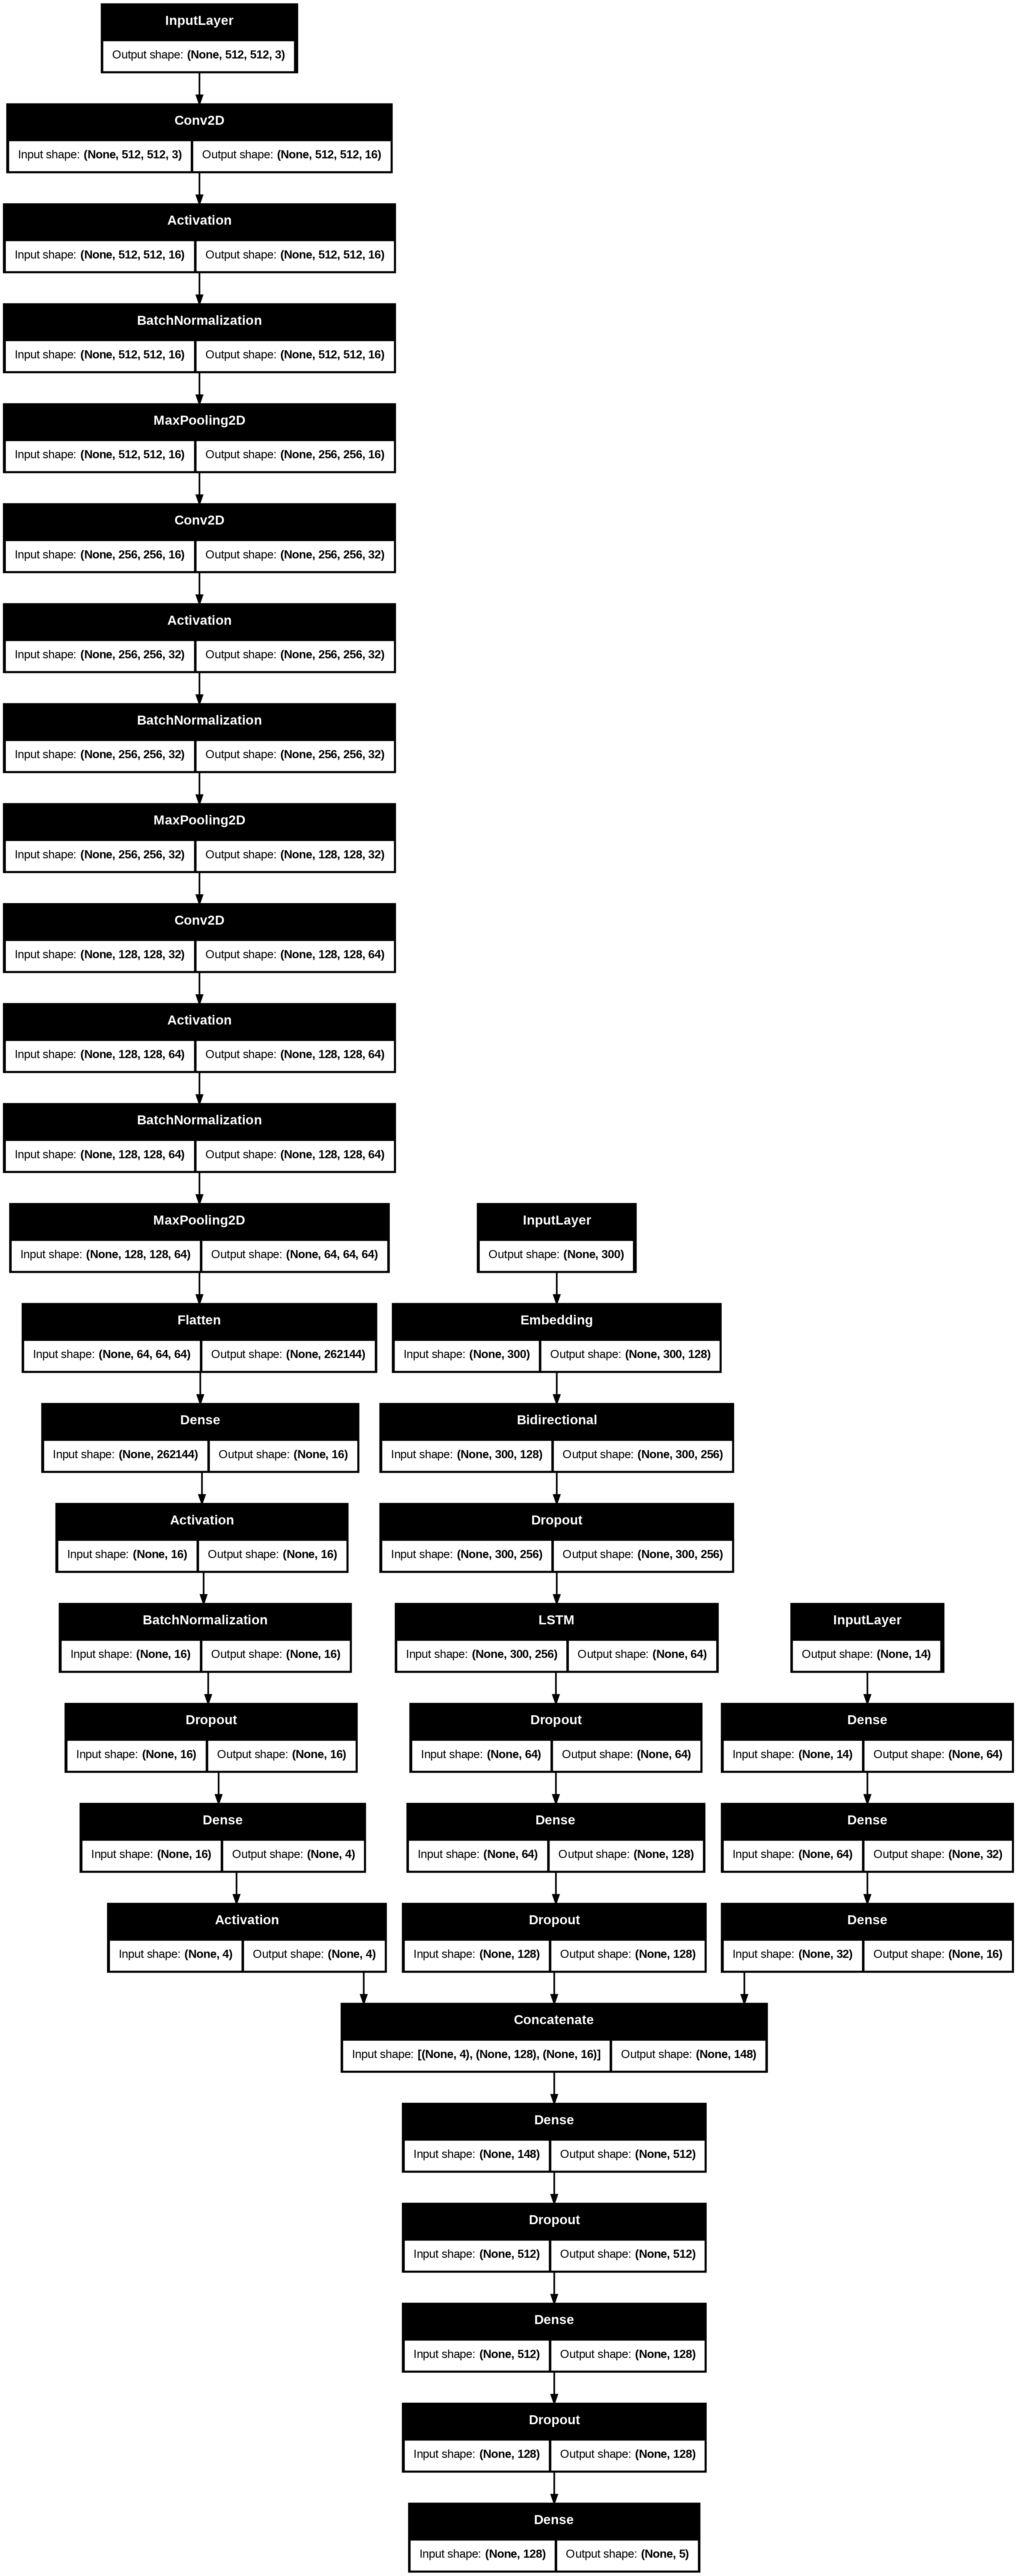

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_path = '/content/drive/My Drive/ML project/Kostas/best_model2.keras'

checkpoint = ModelCheckpoint(
    save_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    [images, text_padded, room_labels_encoded],
    y,
    epochs=400,
    batch_size=48,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.2270 - loss: 1.6193
Epoch 1: val_accuracy improved from -inf to 0.27358, saving model to /content/drive/My Drive/ML project/Kostas/best_model3.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 772ms/step - accuracy: 0.2275 - loss: 1.6189 - val_accuracy: 0.2736 - val_loss: 1.5991
Epoch 2/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.3053 - loss: 1.5562
Epoch 2: val_accuracy did not improve from 0.27358
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 558ms/step - accuracy: 0.3055 - loss: 1.5558 - val_accuracy: 0.2358 - val_loss: 1.6238
Epoch 3/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.3353 - loss: 1.5006
Epoch 3: val_accuracy did not improve from 0.27358
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 564ms/step - accuracy: 0.3354 - loss: 1.5007 - val_accuracy: 0.2296 - val_loss: 1.7002
Epoch 4/400
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.3413 - loss: 1.4632
Epoch 4: val_accuracy did not improve from 0.27358
27/27 ━━━━━━━━━━

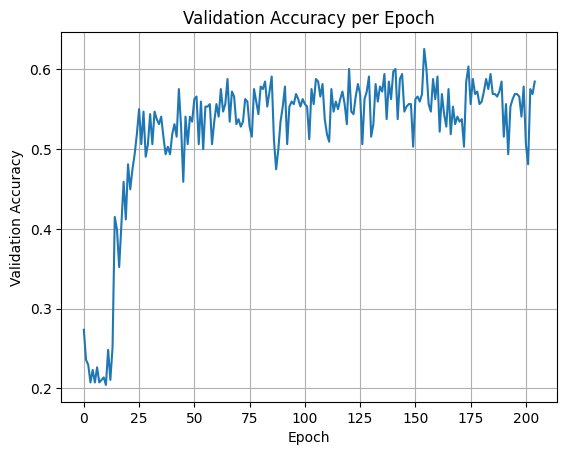

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

In [14]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/My Drive/ML project/Kostas/best_model.keras')

In [7]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

with open('/content/drive/My Drive/ML project/Kostas/tokenizer.json', 'r') as json_file:
    tokenizer_json = json.load(json_file)
    tokenizer = tokenizer_from_json(tokenizer_json)

In [12]:
# Composite Image
images_test = holdout_df['image'].tolist()
images_test = np.array(images_test)

# Property descriptions preprocessing
descriptions = holdout_df['description'].tolist()
cleaned_descriptions = [remove_stopwords(desc, stopwords_set) for desc in descriptions]

text_sequences = tokenizer.texts_to_sequences(cleaned_descriptions)
text_padded_test = pad_sequences(text_sequences, maxlen=291, padding='post')

# Room Types
room_types = holdout_df['room_type'].tolist()
mlb = MultiLabelBinarizer()
room_labels_encoded_test = mlb.fit_transform(room_types)

# Price Label
y_test = holdout_df['price'].values

In [15]:
predictions = best_model.predict([images_test, text_padded_test, room_labels_encoded_test])

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step


In [16]:
predicted_bins = predictions.argmax(axis=1)

In [17]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_bins)

print(f"Holdout Set Accuracy: {accuracy:.4f}")

Holdout Set Accuracy: 0.5028


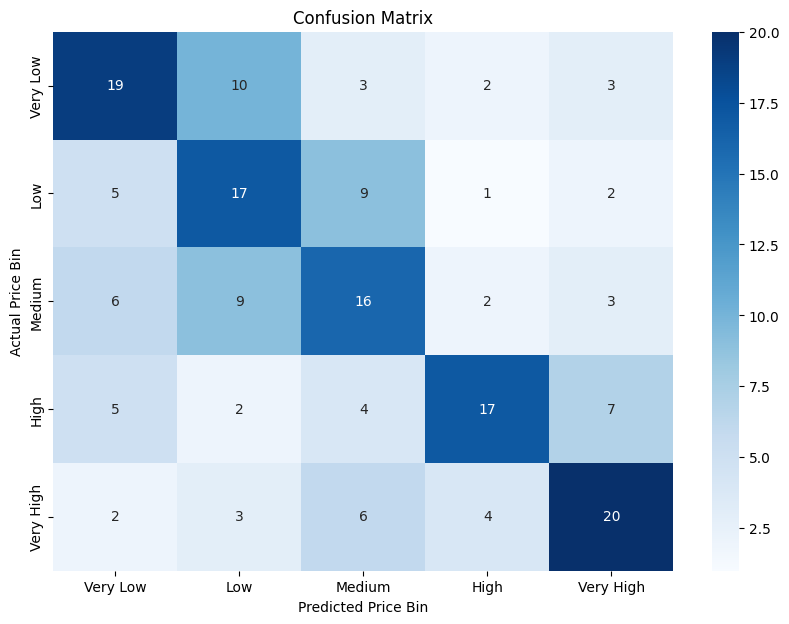

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predicted_bins)
price_bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=price_bin_labels, yticklabels=price_bin_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Price Bin')
plt.ylabel('Actual Price Bin')
plt.show()

In [20]:
holdout_df['predicted_price'] = predicted_bins

In [21]:
mismatched_prices_df = holdout_df[holdout_df['price'] != holdout_df['predicted_price']]
mismatched_prices_df.head(10)

,description,room_type,image,price,actual_price,predicted_price
2,"In the heart of Nea Smyrni, this stunning thir...","[hallway, hallway, hallway, hallway, hallway]","[[[0.8156863, 0.8352941, 0.84705883], [0.81960...",2,230000,1
6,"Piraeus, Apartment For Sale, 40 sq.m., Floor: ...","[dining room, garage, dining room, living room...","[[[0.69411767, 0.6509804, 0.7058824], [0.69019...",0,58000,2
7,On the market is a charming apartment located ...,"[living room, living room, living room, bathro...","[[[0.4745098, 0.47843137, 0.45882353], [0.4627...",2,145000,1
8,"In the heart of Nea Smyrni, a semi-basement ap...","[exterior, garage, exterior, exterior, exterior]","[[[0.5254902, 0.5058824, 0.49019608], [0.52941...",0,55000,1
9,Property Code: 74-1040121. A 5-level residenti...,"[hallway, exterior, hallway, garage, hallway]","[[[0.3529412, 0.4117647, 0.3372549], [0.105882...",4,820000,0
10,"Piraeus Kaminia Detached two-storey house, fur...","[exterior, exterior, garage, living room, livi...","[[[0.68235296, 0.6431373, 0.6039216], [0.84705...",3,480000,0
12,"No Description Located in Mikrolimano, Kastell...","[living room, living room, living room, kitche...","[[[0.5372549, 0.45490196, 0.38039216], [0.5372...",4,1800000,2
15,"In the heart of Lykavittos, a 54sqm apartment ...","[living room, exterior, garage, kitchen, bathr...","[[[0.6117647, 0.60784316, 0.6], [0.5764706, 0....",1,80000,2
17,Property Code: S54 - Apartment FOR SALE in Kip...,"[entry room, entry room, dining room, dining r...","[[[0.6666667, 0.5254902, 0.47058824], [0.69803...",1,120000,2
18,Property Code: 1-1009 - Apartment FOR SALE in ...,"[hallway, hallway, bathroom, entry room, hallway]","[[[0.4745098, 0.39607844, 0.26666668], [0.4705...",2,160000,4


In [27]:
from PIL import Image

def display_random_row(df):

    random_row = df.sample(n=1).iloc[0]

    # Extract the image array and description
    image_array = random_row['image']
    description = random_row['description']

    # Denormalize the image (currently between 0 and 1) to [0, 255]
    image_array = (image_array * 255).astype(np.uint8)

    # Convert the NumPy array to a PIL Image object
    img = Image.fromarray(image_array)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"Description: {description}")
    print(f"Predicted Price Bin: {random_row['predicted_price']}")
    print(f"Actual Price Bin: {random_row['price']}")

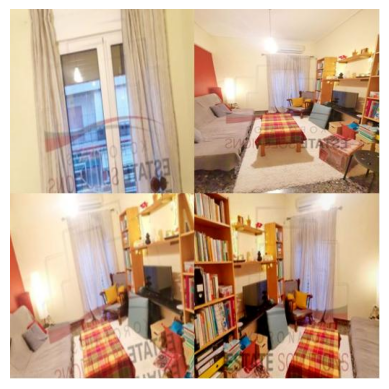

Description: This 59 sq m corner apartment, situated on the 3rd floor, boasts excellent condition and abundant natural light. The well-designed layout includes a reception area, a dining room converted into a functional office space, a spacious living room, a fully renovated kitchen with ample storage, a bathroom with a small storage area above it, and a bedroom featuring large wardrobes and a wooden floor. All rooms have access to the expansive corner balcony, which wraps around the apartment's perimeter and offers stunning views of Filopappou hill. The apartment is equipped with aluminum frames featuring double glazing, screens, and roller shutters, as well as two Toyotomi air conditioners, one in the living room and another in the bedroom. Nestled in a quiet neighborhood, this property enjoys an excellent location, just a 4-minute walk (300 meters) from the electric station in Petralona, an 8-minute walk (600 meters) from Filopappou hill, and an 18-minute walk from Thisio and Kerame

In [53]:
display_random_row(mismatched_prices_df)